# borderline-SMOTE SVM

1. Random Forest Classifier
2. Bagging Classifier
3. XGBoost
4. Gradient Boosting 
5. Extra Trees
6. Gaussian Naïve Bayes
7. CART
8. KNN
9. AdaBoost

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # <-- Use MinMaxScaler here
from imblearn.over_sampling import SVMSMOTE
import os

warnings.filterwarnings("ignore")

# Reading the file
df = pd.read_csv("all_three.csv")

# Dropping the first column because it is of no use  
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Segregating the features and labels 
Y = df[['label']]
X = df[['rec/sent','amount','size','weight','version','lock_time','is_coinbase',
        'has_witness','input_count','output_count','input_total_usd','output_total_usd',
        'fee_usd','fee_per_kb_usd','fee_per_kwu_usd','cdd_total']]

# Apply Min-Max scaling instead of Robust scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Splitting the data (60-40 split)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.4, random_state=42, stratify=Y
) 

# File to save resampled dataset
resampled_file = "x_y_train_resampled_SVMSMOTE.csv"

if not os.path.exists(resampled_file):
    print("Running SVMSMOTE... this may take a long time")
    Borderline_SMOTE_SVM = SVMSMOTE()
    x_res, y_res = Borderline_SMOTE_SVM.fit_resample(x_train, y_train)

    # Merge x and y to save in one CSV
    resampled_df = pd.concat([pd.DataFrame(x_res, columns=x_train.columns), 
                              pd.DataFrame(y_res, columns=["label"])], axis=1)
    resampled_df.to_csv(resampled_file, index=False)
    print(f"Resampled dataset saved to {resampled_file}")
else:
    print("Loading resampled dataset from CSV...")
    resampled_df = pd.read_csv(resampled_file)
    x_res = resampled_df.drop(columns=["label"])
    y_res = resampled_df[["label"]]

# Now x_res, y_res are your oversampled training sets
x_train, y_train = x_res, y_res


Running SVMSMOTE... this may take a long time
Resampled dataset saved to x_y_train_resampled_SVMSMOTE.csv
Resampled dataset saved to x_y_train_resampled_SVMSMOTE.csv


In [ ]:
!pip install seaborn

In [3]:
# -----------------------------
# Required imports
# -----------------------------
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as mplplt  # renamed to avoid overwriting issues
import psutil, os
import pandas as pd
import numpy as np
from time import time

# -----------------------------
# Full check_prediction function
# -----------------------------
def check_prediction(y_true, y_pred, start_time, model=None, x_test=None, x_train=None): 
    runtime_sec = time() - start_time
    
    # RAM usage
    process = psutil.Process(os.getpid())
    ram_used_mb = process.memory_info().rss / (1024 * 1024)
    
    # Base metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    # ROC AUC
    roc_auc = None
    y_probs = None
    try:
        if model is not None and x_test is not None:
            if hasattr(model, "predict_proba"):
                y_probs = model.predict_proba(x_test)
            elif hasattr(model, "decision_function"):
                y_probs = model.decision_function(x_test)

        if y_probs is not None:
            classes = np.unique(y_true)
            y_true_bin = label_binarize(y_true, classes=classes)
            roc_auc = roc_auc_score(y_true_bin, y_probs, average="weighted", multi_class="ovr")
    except Exception as e:
        print(f"⚠ ROC AUC not available: {e}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print("\n===== Evaluation Results =====")
    print(f"runtime_sec: {runtime_sec:.4f}")
    print(f"ram_used_mb: {ram_used_mb:.4f}")
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"roc_auc: {roc_auc:.4f}" if roc_auc else "roc_auc: N/A")
    print("confusion_matrix:\n", cm)
    print("================================\n")

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # -----------------------------
    # Confusion Matrix Heatmap
    # -----------------------------
    fig_cm, ax_cm = mplplt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax_cm)
    ax_cm.set_title("Confusion Matrix")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    mplplt.show()

    # -----------------------------
    # ROC Curve plotting
    # -----------------------------
    if y_probs is not None:
        try:
            if y_probs.ndim > 1 and y_probs.shape[1] > 1:  # multiclass
                n_classes = y_probs.shape[1]
                classes = np.unique(y_true)
                y_true_bin = label_binarize(y_true, classes=classes)

                fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
                    roc_auc_val = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={roc_auc_val:.2f})")

                ax_roc.plot([0,1],[0,1],'k--')
                ax_roc.set_title("ROC Curves (Multiclass)")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                mplplt.show()
            else:  # binary
                if len(np.unique(y_true)) == 2:
                    fpr, tpr, _ = roc_curve(y_true, y_probs)
                    roc_auc_val = auc(fpr, tpr)
                    fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc_val:.2f}")
                    ax_roc.plot([0,1],[0,1],'k--')
                    ax_roc.set_title("ROC Curve (Binary)")
                    ax_roc.set_xlabel("False Positive Rate")
                    ax_roc.set_ylabel("True Positive Rate")
                    ax_roc.legend(loc="lower right")
                    mplplt.show()
        except Exception as e:
            print(f"⚠ ROC plotting failed: {e}")

    # -----------------------------
    # Feature Correlation Heatmap
    # -----------------------------
    if x_train is not None:
        corr = pd.DataFrame(x_train).corr()
        fig_corr, ax_corr = mplplt.subplots(figsize=(10, 8))
        sns.heatmap(corr, cmap="coolwarm", annot=False, ax=ax_corr)
        ax_corr.set_title("Feature Correlation Heatmap")
        mplplt.show()


In [4]:
df['label'].value_counts()
print("training data size")
print(y_train.value_counts())
print("testing data size")
print(y_test.value_counts())

training data size
label
0        201508
1        201508
2        201508
3        201508
Name: count, dtype: int64
testing data size
label
0        134339
2         22156
3         13654
1           901
Name: count, dtype: int64


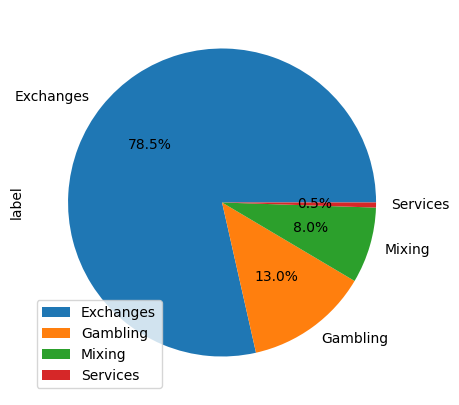

In [5]:
pf2=pd.DataFrame({'label':df['label'].value_counts().to_list()},
                    index=['Exchanges','Gambling', 'Mixing','Services'])

plt=pf2.plot.pie(y='label',autopct='%1.1f%%',figsize=(5,5))

## Random Forest Classifier


===== Evaluation Results =====
runtime_sec: 205.9035
ram_used_mb: 675.6875
accuracy: 0.9616
precision: 0.9635
recall: 0.9616
roc_auc: 0.9909
confusion_matrix:
 [[130407     97     12   3823]
 [   291    605      0      5]
 [    17      0  22138      1]
 [  2323      7      0  11324]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    134339
           1       0.85      0.67      0.75       901
           2       1.00      1.00      1.00     22156
           3       0.75      0.83      0.79     13654

    accuracy                           0.96    171050
   macro avg       0.90      0.87      0.88    171050
weighted avg       0.96      0.96      0.96    171050



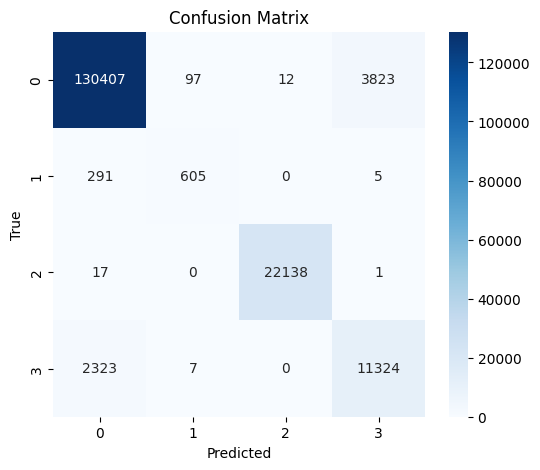

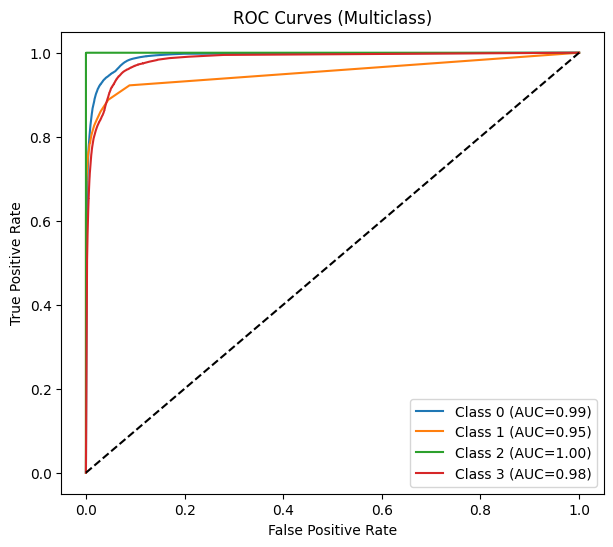

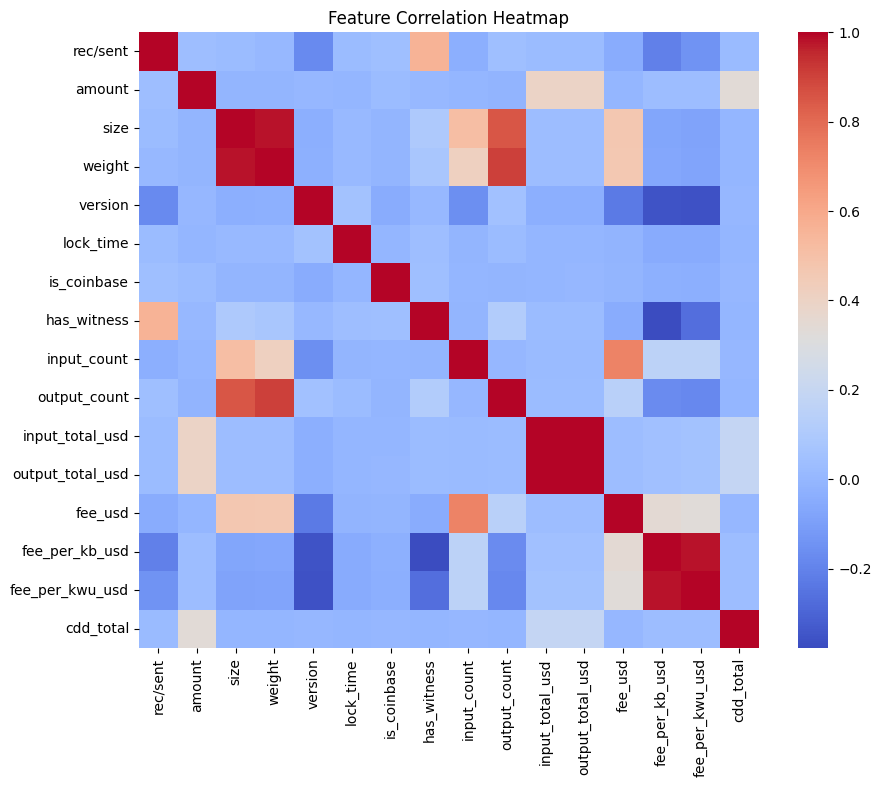

In [6]:
start_time = time()
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier()  
model.fit(x_train, y_train) 

# predicting the model in testing dataset
y_pred = model.predict(x_test)

# Evaluating the model 
check_prediction(y_test, y_pred, start_time, model, x_test, x_train)

In [7]:
import os
import platform

def notify_done():
    system = platform.system()
    if system == "Windows":
        import winsound
        winsound.Beep(1000, 700)   # frequency=1000 Hz, duration=700ms
    elif system == "Darwin":  # macOS
        os.system('say "Task completed"')
    else:  # Linux
        os.system('echo -e "\a"')  # terminal beep

# --- your code ---
print("Starting long process...")

# Place all your ML code here
# ...

print("Process completed!")
notify_done()


Starting long process...
Process completed!


## Bagging Classifier

Cross-validation scores: [0.97017721 0.96984047 0.96981921]
Mean CV score: 0.9699

===== Evaluation Results =====
runtime_sec: 663.9695
ram_used_mb: 576.5508
accuracy: 0.9601
precision: 0.9624
recall: 0.9601
roc_auc: 0.9877
confusion_matrix:
 [[130131    206     17   3985]
 [   269    615      1     16]
 [    18      1  22134      3]
 [  2297     15      2  11340]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    134339
           1       0.73      0.68      0.71       901
           2       1.00      1.00      1.00     22156
           3       0.74      0.83      0.78     13654

    accuracy                           0.96    171050
   macro avg       0.86      0.87      0.87    171050
weighted avg       0.96      0.96      0.96    171050


===== Evaluation Results =====
runtime_sec: 663.9695
ram_used_mb: 576.5508
accuracy: 0.9601
precision: 0.9624
recall: 0.9601
roc_auc: 0.9877
confusion_matrix:
 [[130131  

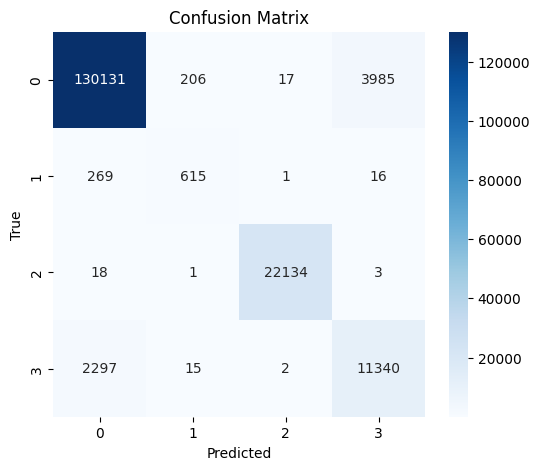

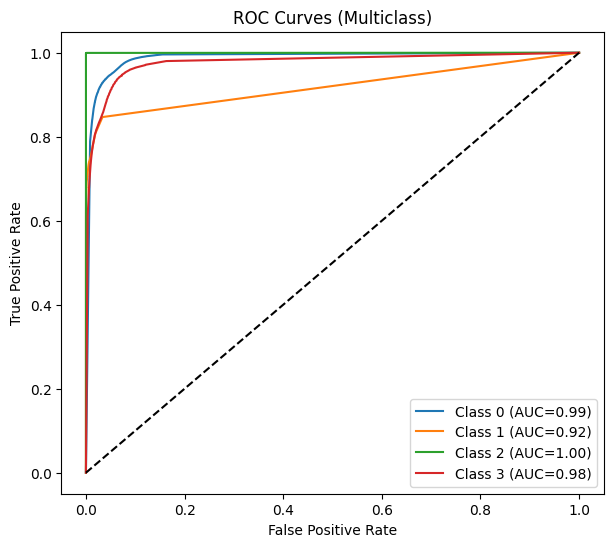

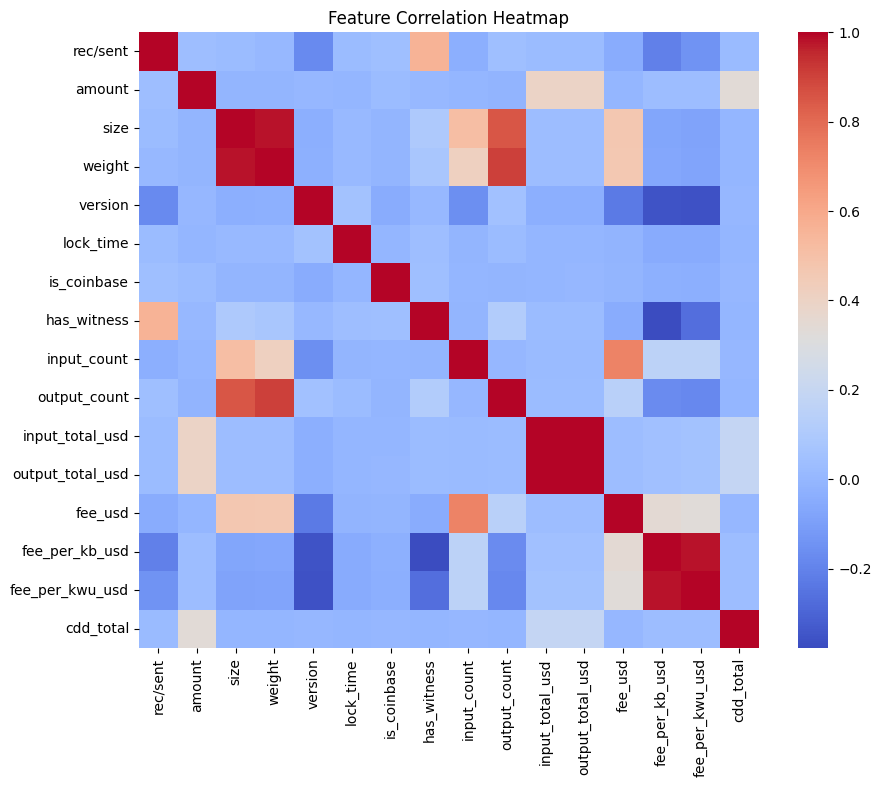

In [8]:
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

# Start timer
current_time = time()

# Initialize the base classifier
base_model = DecisionTreeClassifier()

# Number of base classifiers
n_trees = 50

# Initialize BaggingClassifier (use 'estimator' instead of 'base_estimator')
model = BaggingClassifier(
    estimator=base_model,  # updated argument name
    n_estimators=n_trees,
    random_state=50
)

# Optional: Cross-validation score
kfold = KFold(n_splits=3, shuffle=True, random_state=50)
res = cross_val_score(model, X, Y.values.ravel(), cv=kfold)
print(f"Cross-validation scores: {res}")
print(f"Mean CV score: {res.mean():.4f}")

# Train the model
model.fit(x_train, y_train.values.ravel())

# Predict
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## XGBoost

In [ ]:
!pip install xgboost



===== Evaluation Results =====
runtime_sec: 4.7480
ram_used_mb: 584.1094
accuracy: 0.9361
precision: 0.9573
recall: 0.9361
roc_auc: 0.9928
confusion_matrix:
 [[124526    748     20   9045]
 [   222    666      1     12]
 [     7      0  22147      2]
 [   829     41      0  12784]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    134339
           1       0.46      0.74      0.57       901
           2       1.00      1.00      1.00     22156
           3       0.59      0.94      0.72     13654

    accuracy                           0.94    171050
   macro avg       0.76      0.90      0.81    171050
weighted avg       0.96      0.94      0.94    171050



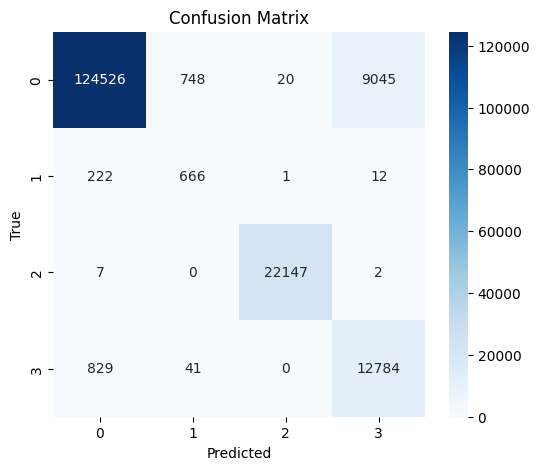

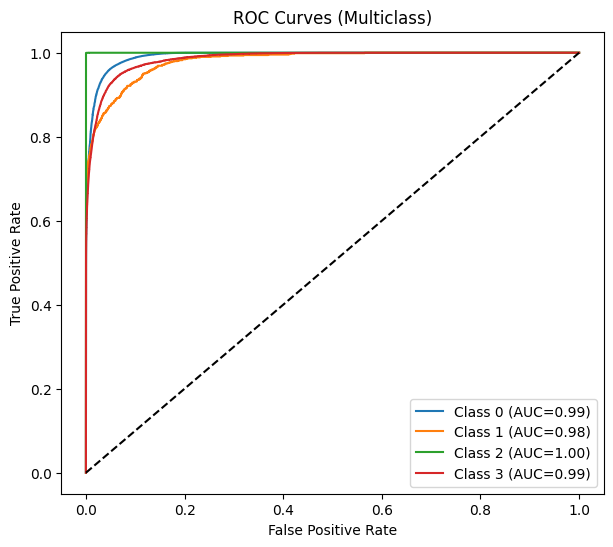

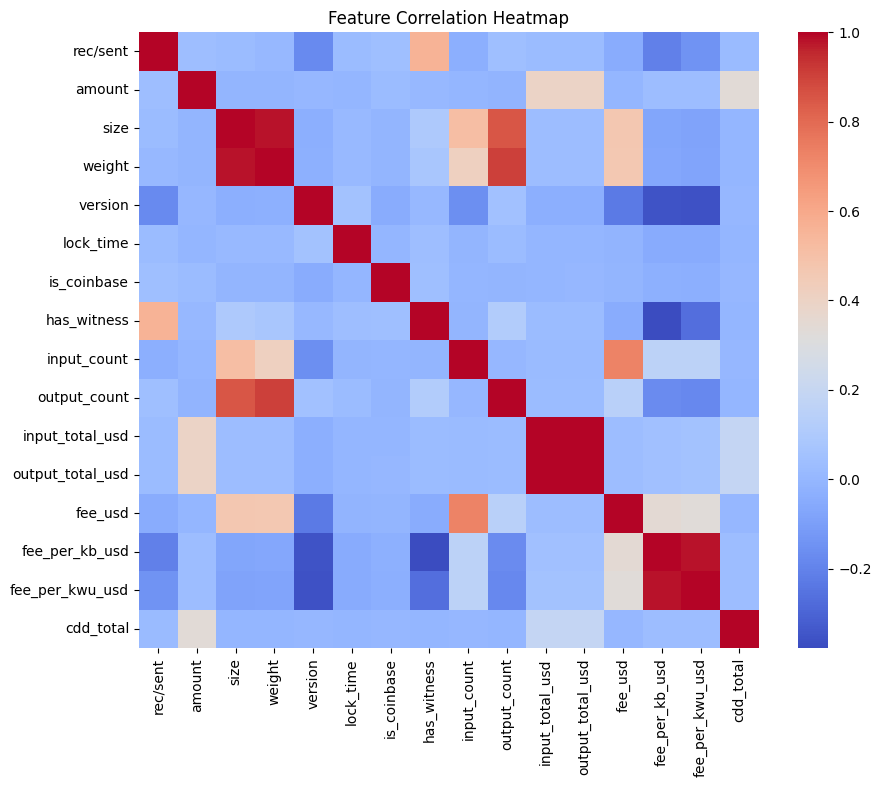

In [9]:
from time import time
from xgboost import XGBClassifier

# Start timer
current_time = time()

# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # avoid warning
model.fit(x_train, y_train.values.ravel())

# Predict the test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## Gradient Boosting


===== Evaluation Results =====
runtime_sec: 1091.0723
ram_used_mb: 704.4570
accuracy: 0.8862
precision: 0.9466
recall: 0.8862
roc_auc: 0.9868
confusion_matrix:
 [[116016   4648    297  13378]
 [   163    718      4     16]
 [     2      0  22153      1]
 [   726    229      9  12690]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    134339
           1       0.13      0.80      0.22       901
           2       0.99      1.00      0.99     22156
           3       0.49      0.93      0.64     13654

    accuracy                           0.89    171050
   macro avg       0.65      0.90      0.69    171050
weighted avg       0.95      0.89      0.91    171050



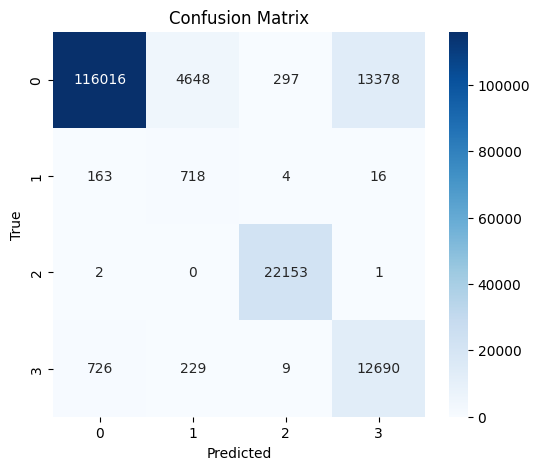

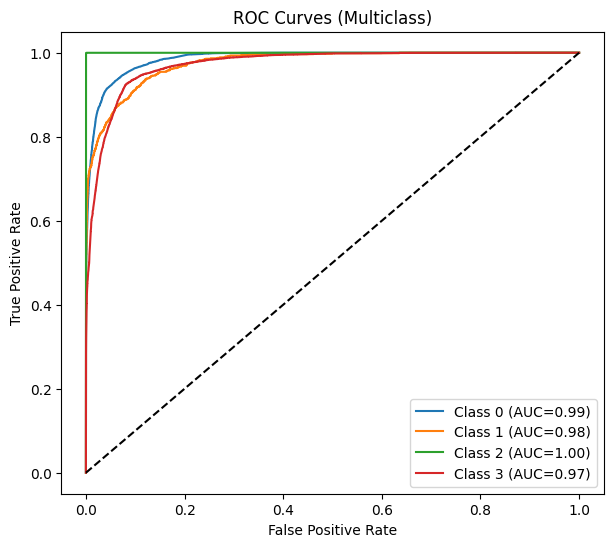

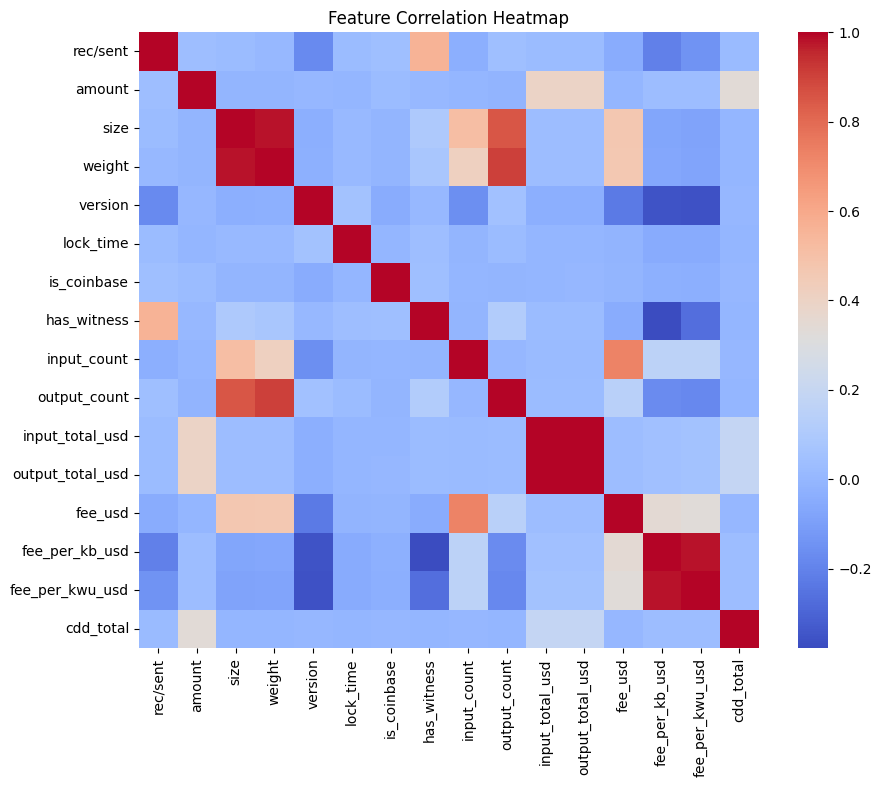

In [10]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier

# Start timer
current_time = time()

# Initialize GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train.values.ravel())  # flatten to 1D if needed

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Extra Trees

F1-score: 0.8343588473180645

===== Evaluation Results =====
runtime_sec: 8.5502
ram_used_mb: 714.7070
accuracy: 0.8102
precision: 0.8981
recall: 0.8102
roc_auc: 0.9748
confusion_matrix:
 [[104561   6019  12588  11171]
 [   188    466    102    145]
 [     5    135  22016      0]
 [   931    444    739  11540]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    134339
           1       0.07      0.52      0.12       901
           2       0.62      0.99      0.76     22156
           3       0.50      0.85      0.63     13654

    accuracy                           0.81    171050
   macro avg       0.55      0.78      0.60    171050
weighted avg       0.90      0.81      0.83    171050


===== Evaluation Results =====
runtime_sec: 8.5502
ram_used_mb: 714.7070
accuracy: 0.8102
precision: 0.8981
recall: 0.8102
roc_auc: 0.9748
confusion_matrix:
 [[104561   6019  12588  11171]
 [   188    466    102    145]
 [   

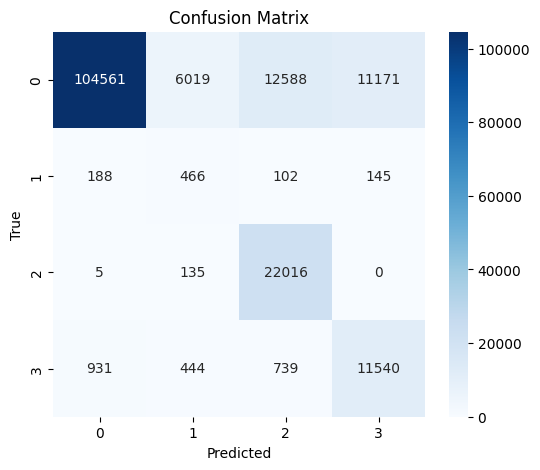

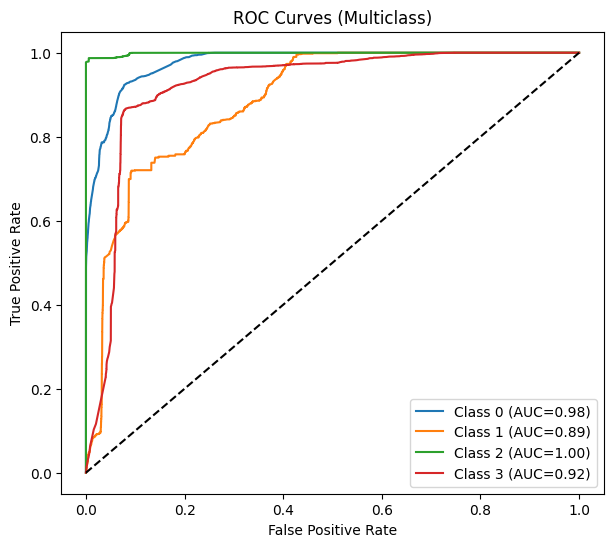

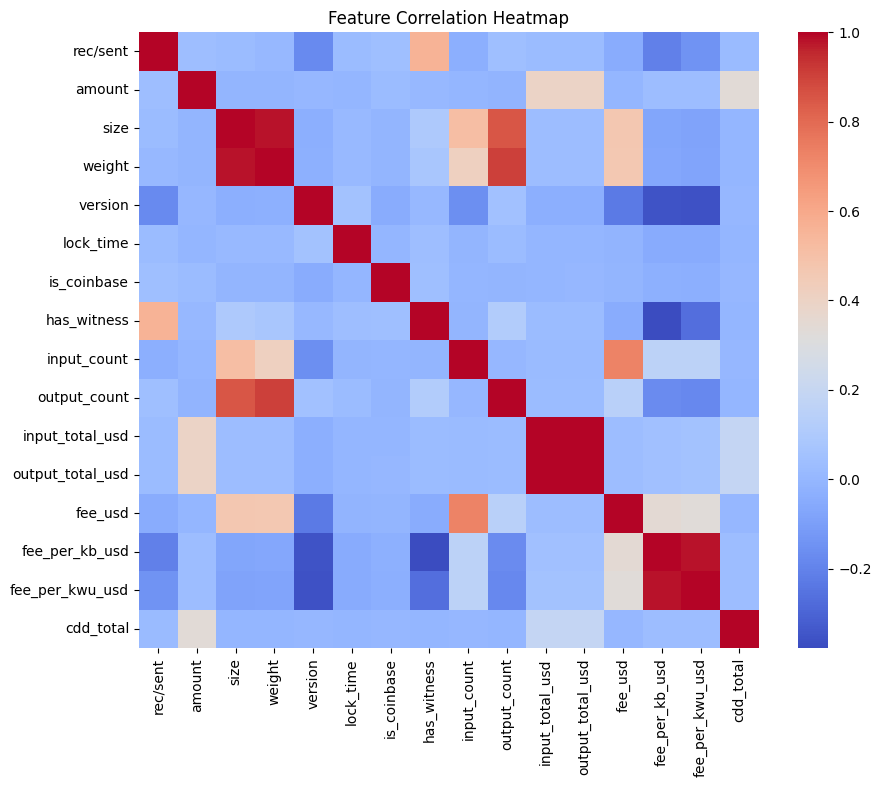

In [11]:
from time import time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

# Start timer
current_time = time()

# Initialize ExtraTreesClassifier
clf = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Train the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = clf.predict(x_test)

# Evaluate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Evaluate with check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## Gaussian Naïve Bayes


===== Evaluation Results =====
runtime_sec: 0.2547
ram_used_mb: 719.2656
accuracy: 0.1869
precision: 0.8524
recall: 0.1869
roc_auc: 0.8883
confusion_matrix:
 [[28772 99439  1126  5002]
 [   12   884     3     2]
 [    4 21059  1046    47]
 [  367 11986    36  1265]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.21      0.35    134339
           1       0.01      0.98      0.01       901
           2       0.47      0.05      0.09     22156
           3       0.20      0.09      0.13     13654

    accuracy                           0.19    171050
   macro avg       0.42      0.33      0.14    171050
weighted avg       0.85      0.19      0.30    171050



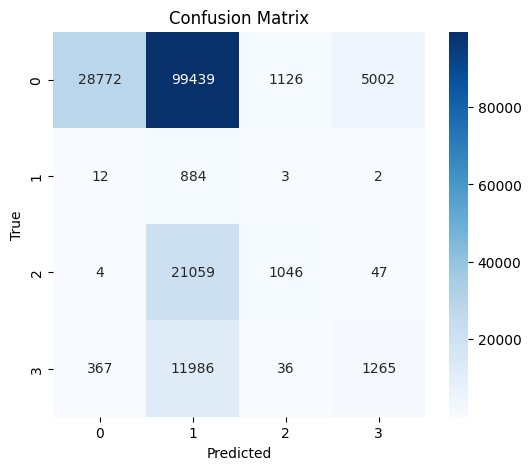

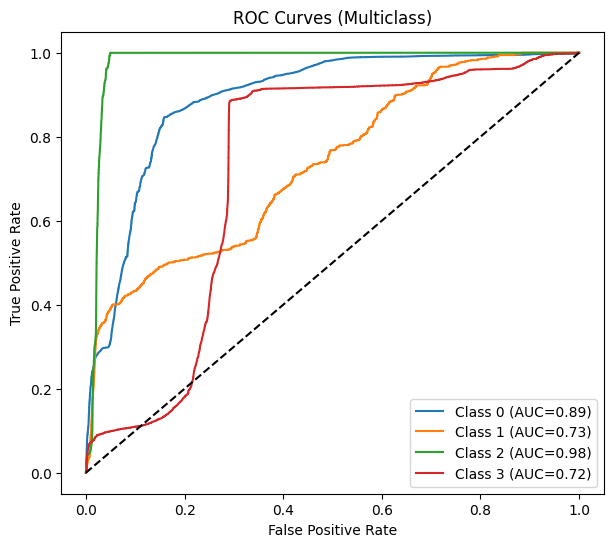

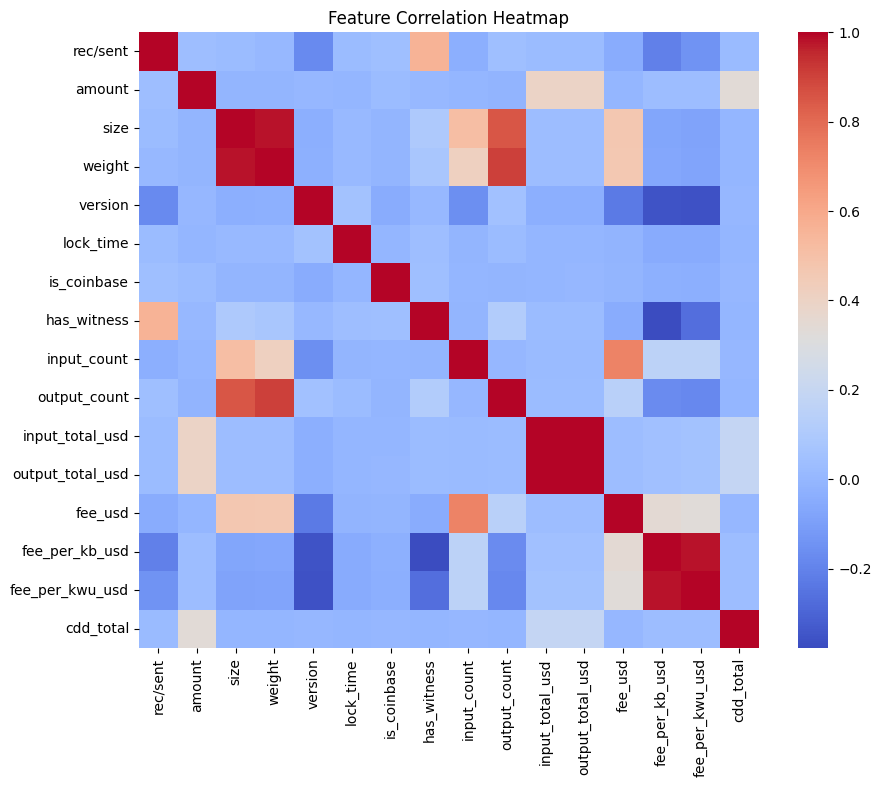

In [12]:
from time import time
from sklearn.naive_bayes import GaussianNB

# Start timer
current_time = time()

# Initialize Gaussian Naive Bayes
model = GaussianNB()

# Train the model
model.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Classification and Regression Trees (CART)


===== Evaluation Results =====
runtime_sec: 2.6856
ram_used_mb: 725.2773
accuracy: 0.7343
precision: 0.9233
recall: 0.7343
roc_auc: 0.9234
confusion_matrix:
 [[90733 15781  2083 25742]
 [  130   543    45   183]
 [    5   152 21955    44]
 [  484   641   157 12372]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.68      0.80    134339
           1       0.03      0.60      0.06       901
           2       0.91      0.99      0.95     22156
           3       0.32      0.91      0.48     13654

    accuracy                           0.73    171050
   macro avg       0.56      0.79      0.57    171050
weighted avg       0.92      0.73      0.79    171050



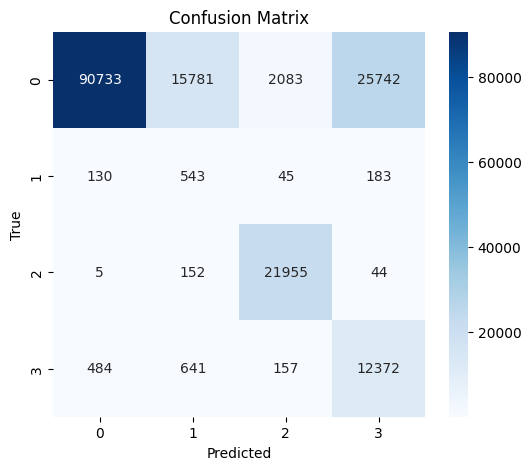

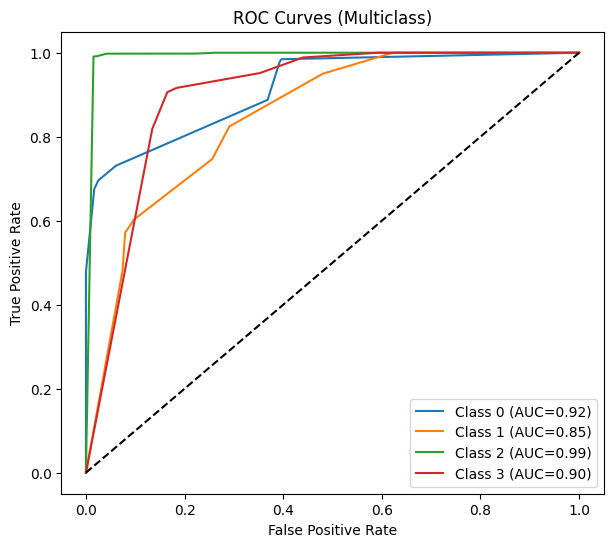

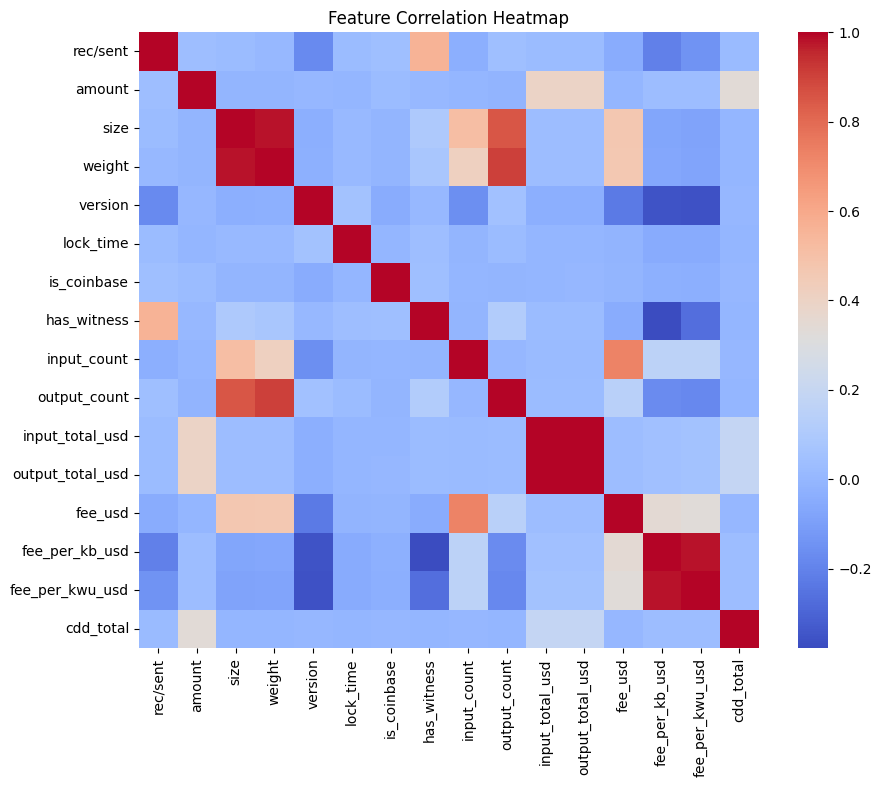

In [13]:
from time import time
from sklearn.tree import DecisionTreeClassifier

# Start timer
current_time = time()

# Create Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Make predictions on test data
y_pred = clf.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## K-Nearest Neighbours


===== Evaluation Results =====
runtime_sec: 69.9319
ram_used_mb: 774.0508
accuracy: 0.9460
precision: 0.9568
recall: 0.9460
roc_auc: 0.9663
confusion_matrix:
 [[127441   1374     32   5492]
 [   274    597      5     25]
 [    15      2  22136      3]
 [  1953     62      0  11639]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    134339
           1       0.29      0.66      0.41       901
           2       1.00      1.00      1.00     22156
           3       0.68      0.85      0.76     13654

    accuracy                           0.95    171050
   macro avg       0.74      0.87      0.78    171050
weighted avg       0.96      0.95      0.95    171050



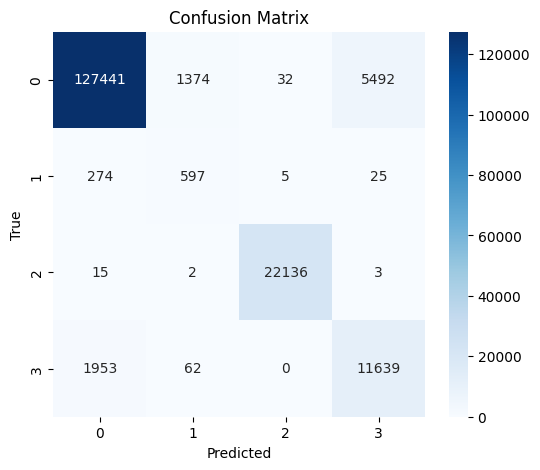

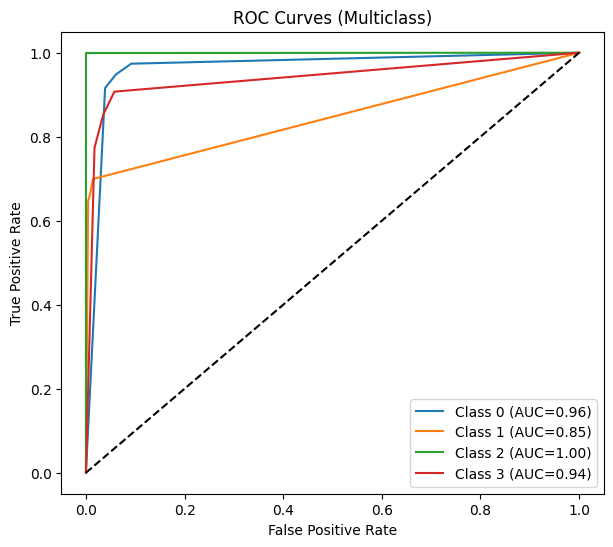

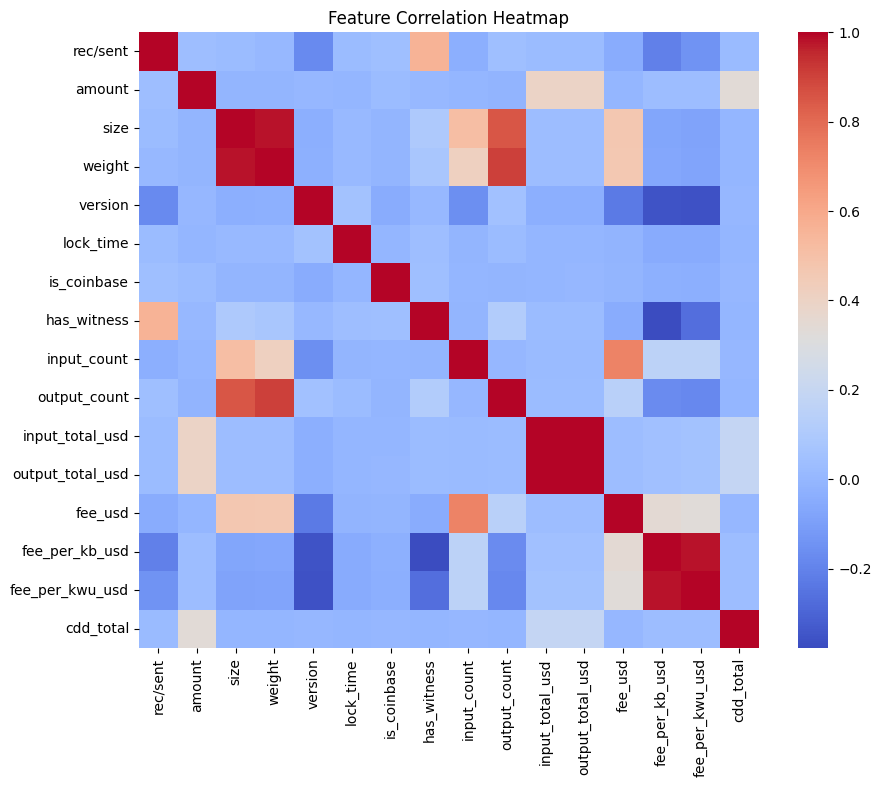

In [14]:
from time import time
from sklearn.neighbors import KNeighborsClassifier

# Start timer
current_time = time()

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = knn.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=knn,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


##  Adaboost


===== Evaluation Results =====
runtime_sec: 55.2878
ram_used_mb: 781.9961
accuracy: 0.7836
precision: 0.9253
recall: 0.7836
roc_auc: 0.9361
confusion_matrix:
 [[99468 12652  1575 20644]
 [  153   679    14    55]
 [  186    16 21954     0]
 [  939   718    65 11932]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.74      0.85    134339
           1       0.05      0.75      0.09       901
           2       0.93      0.99      0.96     22156
           3       0.37      0.87      0.52     13654

    accuracy                           0.78    171050
   macro avg       0.58      0.84      0.60    171050
weighted avg       0.93      0.78      0.83    171050



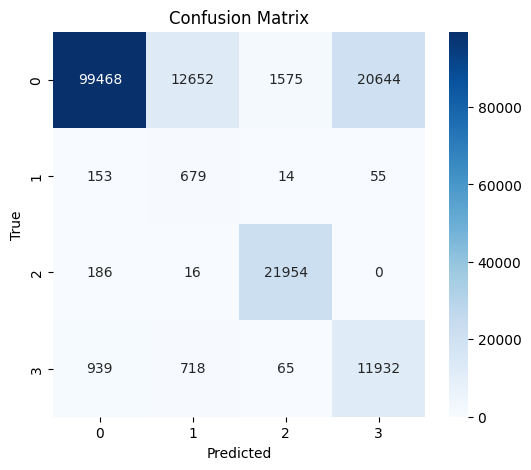

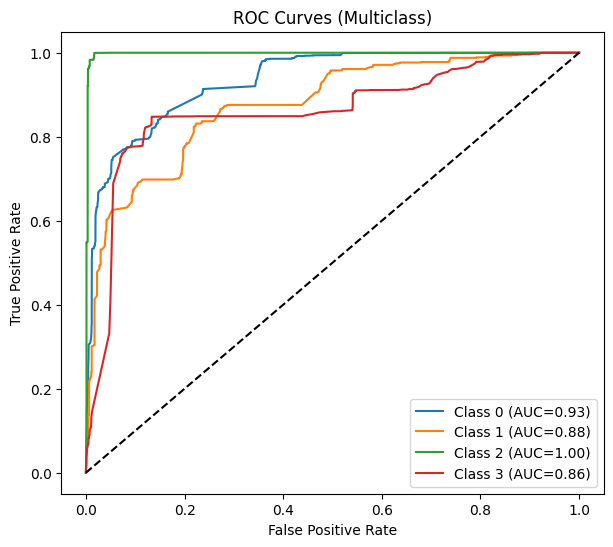

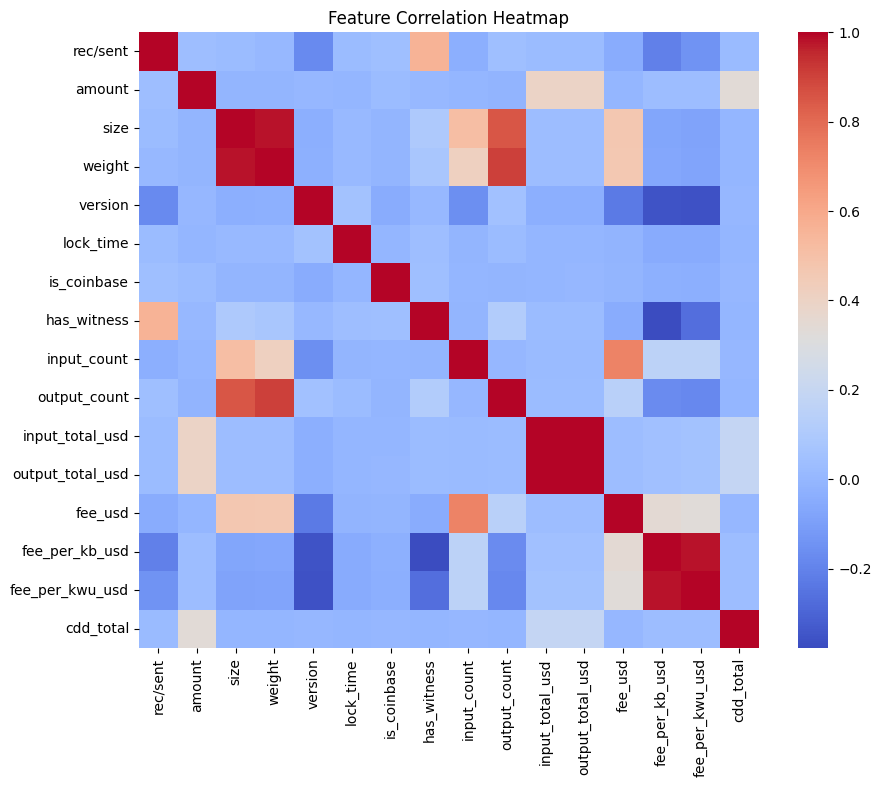

In [15]:
from time import time
from sklearn.ensemble import AdaBoostClassifier

# Start timer
current_time = time()

# Initialize AdaBoost classifier
adboost = AdaBoostClassifier()
adboost.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = adboost.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=adboost,    # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


In [16]:
import os
import platform

def notify_done():
    system = platform.system()
    if system == "Windows":
        import winsound
        winsound.Beep(1000, 700)   # frequency=1000 Hz, duration=700ms
    elif system == "Darwin":  # macOS
        os.system('say "Task completed"')
    else:  # Linux
        os.system('echo -e "\a"')  # terminal beep

# --- your code ---
print("Starting long process...")

# Place all your ML code here
# ...

print("Process completed!")
notify_done()


Starting long process...
Process completed!
